# Football Player Value Prediction – Project Notebook

🗂️ Outline

1. DATA PREPARATION
- 1.1 Overview of the dataset
    - 1.1.1 Data set properties
- 1.2 Cleaning process
    - 1.2.1 Checking missing values
    - 1.2.2 Applying the cleaning strategy
    - 1.2.3 Checking database consistency
    - 1.2.4 Final Checks
- 1.3 Key Features
    - 1.3.1 Distribution of key features
    - 1.3.2 Boxplot Analysis
- 1.4 Clean Data Download
- 1.5 Correlation among features  with value_eur

2. Past Models
- 2.1 Linear Regression
- 2.2 Random Forest

3. Final Model
- 3.1 LightGBM


---

# DATA PREPARATION
## 1.1| Overview of the dataset

In [ ]:
# Import necessary libraries 
# #Make sure pandas is installed in environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/submission.csv')

# Quick overview
train.head() # Display first few rows of the train dataset

📐 Train shape: (15391, 76)
📐 Test shape: (3848, 75)

 Data Type Summary in Train Set:
Empty DataFrame
Columns: [Data Type, Count]
Index: []

 Number of float columns: 15
 Number of int columns: 45
 Number of object columns: 16

 Table of Features by Data Type:
               Float Features                 Int Features  \
0                   value_eur                   Unnamed: 0   
1                    wage_eur                           id   
2                club_team_id                      overall   
3                league_level                    potential   
4          club_jersey_number                          age   
5   club_contract_valid_until                    height_cm   
6        nation_jersey_number                    weight_kg   
7          release_clause_eur               nationality_id   
8                        pace                    weak_foot   
9                    shooting                  skill_moves   
10                    passing     international_reputatio

### 1.1.1| Data set properties

In [ ]:
# 1. Dimensions
print(f"📐 Train shape: {train.shape}")
print(f"📐 Test shape: {test.shape}")

# 2. Data types summary
dtype_counts = train.dtypes.value_counts()
dtype_df = pd.DataFrame(dtype_counts, columns=['Count']).reset_index()
dtype_df.columns = ['Data Type', 'Count']
print("\n Data Type Summary in Train Set:")
print(dtype_df)

# 3. Full list of columns by type
float_cols = train.select_dtypes(include='float').columns.tolist()
int_cols = train.select_dtypes(include='int').columns.tolist()
object_cols = train.select_dtypes(include='object').columns.tolist()
print(f"\n Number of float columns: {len(float_cols)}")
print(f" Number of int columns: {len(int_cols)}")
print(f" Number of object columns: {len(object_cols)}") 

dtype_list_table = pd.DataFrame({
    "Float Features": pd.Series(float_cols),
    "Int Features": pd.Series(int_cols),
    "Object Features (Categorical)": pd.Series(object_cols)
})
print("\n Table of Features by Data Type:")
print(dtype_list_table)

# 4. Define categorical vs numerical
categorical_features = object_cols
numerical_features = float_cols + int_cols
print(f"\n Number of Numerical Features: {len(numerical_features)}")
print(f" Number of Categorical Features: {len(categorical_features)}")

cat_num_df = pd.DataFrame({
    "Categorical Features": pd.Series(categorical_features),
    "Numerical Features": pd.Series(numerical_features)
})
print("\n Categorical vs Numerical Features:")
print(cat_num_df)

---
## 1.2| Cleaning process

### 1.2.1| Checking missing values

We define a function which summarizes:
* how many missing values each column has
* what % of data is missing
* only columns with missing values are shown
* results are sorted from worst to best

We check both Train and Test datasets, and merge the results for easy comparison.

In [ ]:
# Function to summarize missing values
def missing_summary(df, dataset_name="Dataset"):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    missing_table = pd.concat([total, percent], axis=1)
    missing_table.columns = [f'Missing Values ({dataset_name})', f'% Missing ({dataset_name})']
    missing_table = missing_table[missing_table[f'Missing Values ({dataset_name})'] > 0]
    return missing_table.sort_values(f'% Missing ({dataset_name})', ascending=False)

# Summarizing missing values for train and test
missing_train = missing_summary(train, "Train")
missing_test = missing_summary(test, "Test")

# Merging both summaries together
missing_values = missing_train.merge(missing_test, how='outer', left_index=True, right_index=True)

# Sorting the missing values table
missing_values = missing_values.sort_values(by='% Missing (Train)', ascending=False)

# Display missing values table
missing_values

,Missing Values (Train),% Missing (Train),Missing Values (Test),% Missing (Test)
nation_position,14786,96.069131,3694.0,95.997921
nation_jersey_number,14786,96.069131,3694.0,95.997921
club_loaned_from,14515,94.308362,3622.0,94.126819
player_tags,14231,92.463128,3567.0,92.697505
goalkeeping_speed,13662,88.766162,3445.0,89.527027
player_traits,7936,51.562602,1905.0,49.506237
dribbling,1729,11.233838,403.0,10.472973
shooting,1729,11.233838,403.0,10.472973
passing,1729,11.233838,403.0,10.472973
physic,1729,11.233838,403.0,10.472973


###  1.2.2| Applying the cleaning strategy

After analyzing the missing values, we decided cleaning actions based on two criteria:
- % of missing values;
- importance of each column for predicting player market value

Actions applied:
* DROP columns with too many missing values (>50%) -> if they are not critical 
* FILL missing values in numerical columns -> using median to avoid influence from outliers
* FILL missing values in categorical columns -> with 'unknown'

In [ ]:
# DROP columns
# too many missing values + not critical for predicting market value
columns_to_drop = [
    'player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 
    'nation_position', 'goalkeeping_speed'] 
train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test.drop(columns=columns_to_drop, inplace=True, errors='ignore')
# Quick check
print("Dropped columns from train:", columns_to_drop)
print("Dropped columns from test:", columns_to_drop)

In [ ]:
# FILL missing values in numerical columns
# with median
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_cols: 
    median_value = train[column].median()
    train[column] = train[column].fillna(median_value)
# because test doesn't have value_eur
# Drop 'value_eur' from test set
numerical_cols_test=numerical_cols.drop('value_eur')
for column in numerical_cols_test: 
    median_value = test[column].median()
    test[column] = test[column].fillna(median_value)
# Quick check
print("Train numerical columns after filling:", train[numerical_cols].isnull().sum())
print("Test numerical columns after filling:", test[numerical_cols_test].isnull().sum())

In [ ]:
# FILL missing values in categorical columns
# with 'Unknown'
categorical_cols = train.select_dtypes(include=['object']).columns
for column in categorical_cols:
    train[column] = train[column].fillna('Unknown')
    test[column] = test[column].fillna('Unknown')   
# Quick check
print("Train categorical columns after filling:", train[categorical_cols].isnull().sum())
print("Test categorical columns after filling:", test[categorical_cols].isnull().sum())

Dropped columns from train: ['player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 'nation_position', 'goalkeeping_speed']
Dropped columns from test: ['player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 'nation_position', 'goalkeeping_speed']
Train numerical columns after filling: Unnamed: 0                     0
overall                        0
potential                      0
value_eur                      0
wage_eur                       0
age                            0
height_cm                      0
weight_kg                      0
club_team_id                   0
league_level                   0
club_jersey_number             0
club_contract_valid_until      0
nationality_id                 0
weak_foot                      0
skill_moves                    0
international_reputation       0
release_clause_eur             0
pace                           0
shooting                       0
passing                        0
dribbling   

In [ ]:
# FILL remaining missing values -> with 'Unknown'
train.fillna('Unknown', inplace=True)
test.fillna('Unknown', inplace=True)

# Last check
print("Remaining missing values in train:", train.isnull().sum().sum())
print("Remaining missing values in test:", test.isnull().sum().sum())

### 1.2.3| Checking database Consistency

Before training our models, we made sure that the training and test datasets had the same structure.

Since the training set includes the target variable value_eur, which is not present in the test set as it still needs to be predicted, we temporarily removed this column from the training data. This allowed us to  compare the structure of the two datasets and ensure consistency before proceeding with model training.

In [10]:
train_features = train.drop(columns=['value_eur']) 

# Checking if train and test datasets have the same columns
train_columns = set(train_features.columns)
test_columns = set(test.columns)

if train_columns != test_columns:
    print("Mismatch in columns between train and test datasets:")
    print("Columns in train but not in test:", train_columns - test_columns)
    print("Columns in test but not in train:", test_columns - train_columns)
else:
    print("Train and test datasets have the same columns.")

Train and test datasets have the same columns.



### 1.2.4| Final Checks


In [26]:
# Checking for unexpected missing values
missing_train = train.isnull().sum()[train.isnull().sum() > 0]
if missing_train.empty:
    print("No unexpected missing values in train dataset. ")
else:
    print(missing_train)

missing_test = test.isnull().sum()[test.isnull().sum() > 0]
if missing_test.empty:
    print("No unexpected missing values in test dataset. ")
else:
    print(missing_test)

No unexpected missing values in train dataset. 
No unexpected missing values in test dataset. 


---
## 1.3| KEY FEATURES 

Before building our  predictive models, we we carried out an exploratory analysis to better understand the data. 
We looked at:
* how data is distributed
* how different features relate to each other 
* which might be the most important feature for predicting a player's market value

This early analysis helps us decide which features might be most useful for modeling.


### 1.3.1| Distribution of key features 

We started by plotting histograms of some important features such as age, rating, potential, and wage. 

This helped us gain  insights into:
	•	the range and distribution of player attributes,
	•	the presence of outliers that may require special attention,
	•	whether the data is skewed or symmetric.

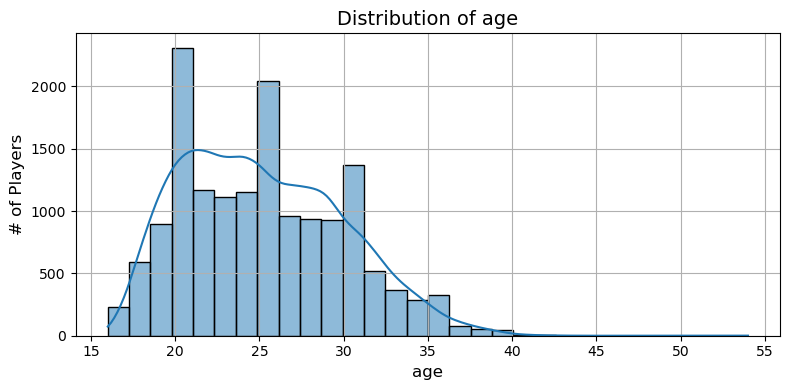

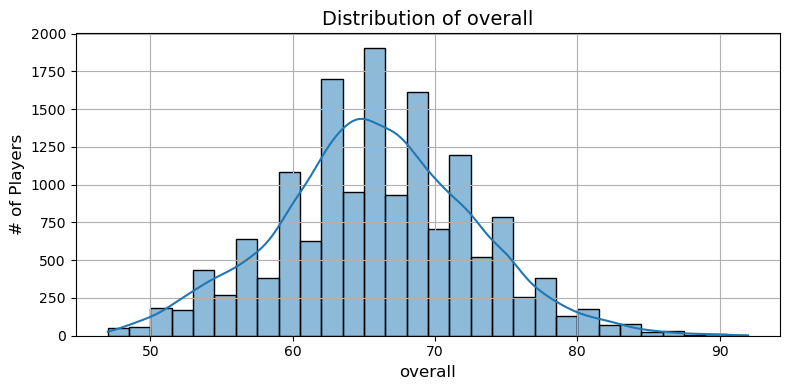

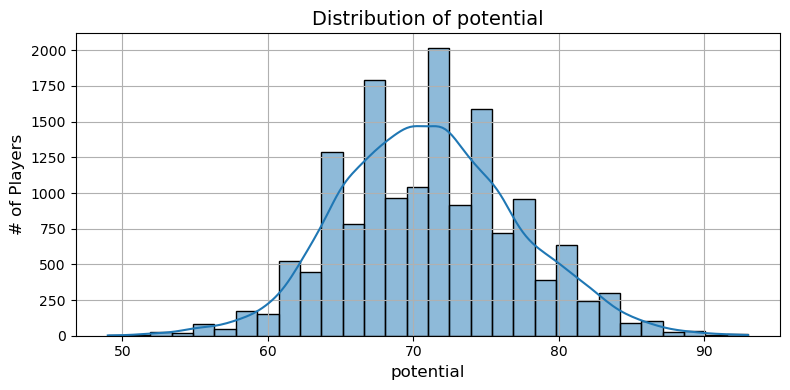

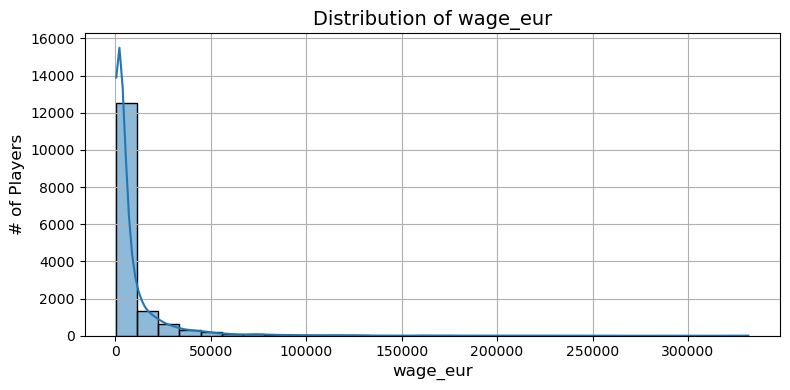

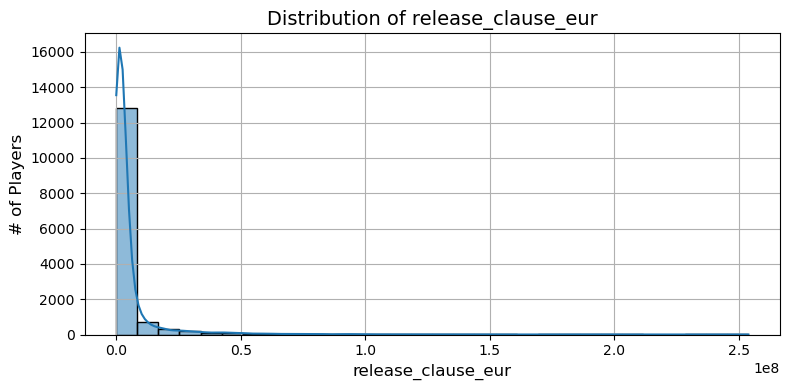

In [ ]:
# Import libraries
import seaborn as sns
train = pd.read_csv('../data/train.csv')# Load the dataset

# Define the key features to visualize
# These features are chosen based on their relevance to player performance and market value
features = ['age', 'overall', 'potential', 'wage_eur', 'release_clause_eur']

# Plot histograms for each feature
for f in features:
    plt.figure(figsize=(8, 4)) 
    sns.histplot(data=train, x=f, kde=True, bins=30)  # Plot histogram with KDE (smooth curve)
    plt.title(f'Distribution of {f}', fontsize=14) 
    plt.xlabel(f, fontsize=12)  
    plt.ylabel('# of Players', fontsize=12)  
    plt.grid(True)  
    plt.tight_layout()  
    plt.show() 

### Distribution Summary Table

| Feature        | Main Range         | Peak  | Shape        | Outliers / Comments                                 |
|-----------------|---------------------|----------------------|--------------|-----------------------------------------------------|
| Age             | 18–25 years         | 20–21 years           | Right-skewed | A few players over 35 |
| Overall         | 60–80       | 62–75          | Symmetrical  | Smal group of top-rated players (>85)                   |
| Potential       | 65–85      | 72–74       | Symmetrical  | Rare players have potential >90       |
| Wage (wage_eur) | 0–100K euros/week   | 0–20K euros/week      | Highly right-skewed | Few players earning >100K euros/week              |
| Release Clause (release_clause_eur) | 0–50M euros        | 0–10M euros          | Highly right-skewed | Some exceptional cases with clauses over 50M |


### 1.3.2| Boxplot analysis 

After analyzing the general distribution of the main features using histograms, we now employ boxplots to :
* Gain deeper insights into the data spread;
* Identify potential outliers.



In [28]:
# Key features
features = ['age', 'overall', 'potential', 'wage_eur', 'release_clause_eur']
train[features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,15391.0,2.521090e+01,4.753887e+00,16.000000,21.000000,2.500000e+01,2.900000e+01,5.400000e+01
overall,15391.0,6.576987e+01,6.890025e+00,47.000000,61.000000,6.600000e+01,7.000000e+01,9.200000e+01
potential,15391.0,7.108622e+01,6.112911e+00,49.000000,67.000000,7.100000e+01,7.500000e+01,9.300000e+01
wage_eur,15342.0,8.610310e+03,1.855964e+04,456.558174,947.936111,2.841617e+03,7.683740e+03,3.316805e+05
release_clause_eur,14457.0,5.367525e+06,1.478709e+07,16000.000000,798000.000000,1.600000e+06,3.600000e+06,2.539000e+08


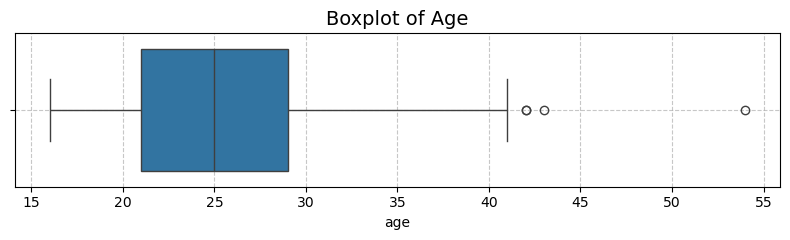

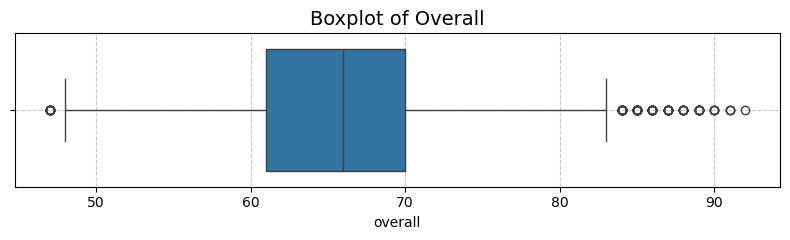

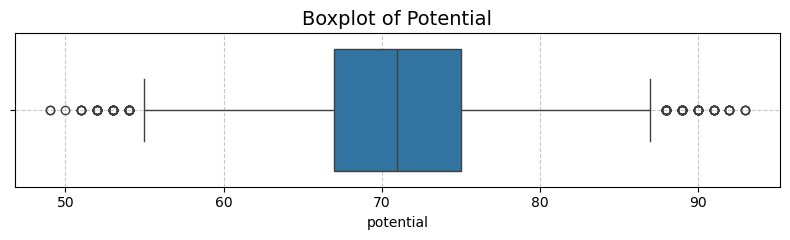

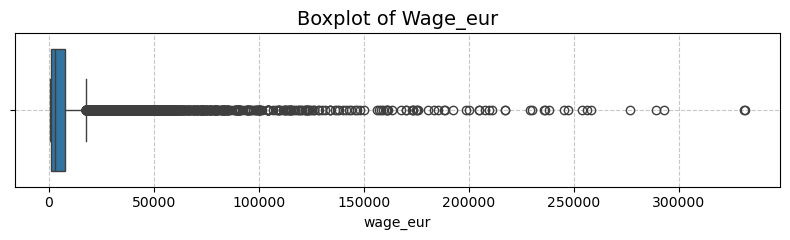

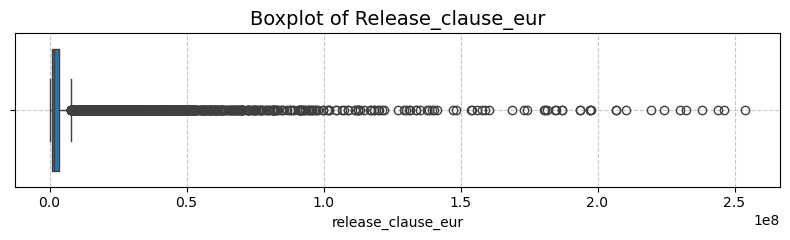

In [29]:
# Plot boxplots
for f in features:
    plt.figure(figsize=(8, 2.5))
    sns.boxplot(data=train, x=f)
    plt.title(f'Boxplot of {f.capitalize()}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Boxplot Summary Table

| Feature              | Median (approx.) | Spread (IQR)             | Outliers Observed?         |
|----------------------|------------------|---------------------------|-----------------------------|
| Age                  | ~22 years         | 20–25 years               | A few above 35       |
| Overall              | ~70 rating        | 65–75              | A few above 85             | 
| Potential            | ~75 rating        | 70–80              | Several above 90            | 
| Wage (wage_eur)      | ~10K €/week        | 0–20K €/week              | Many above 100k | 
| Release Clause (release_clause_eur) | ~5M €            | 0–10M €                  | A few above 50M  | 

---
## 1.4| Removing unnecessary features and downloading clean data set

##### Feature Removal Justification

| Feature           | Reason for Removal                                                                 |
|-------------------|------------------------------------------------------------------------------------|
| `id`              | Unique identifier with no predictive value.                                        |
| `nationality_name`| High cardinality and difficult to encode meaningfully for prediction. Similar to nationality_id.             |
| `long_name`       | Just a display name; offers no useful numerical or categorical signal.            |
| `short_name`      | Redundant with `long_name`; not informative for modeling.                         |
| `dob`             | The raw date of birth is difficult to use directly and is already captured more usefully as the `age` feature. |
| `club_joined`     | Date field that may be inconsistent or redundant with other tenure or club-related features. |

In [36]:
# Remove unimportant identity columns before correlation  
columns_to_remove = [ 'id', 'nationality_name',
    'long_name', 'short_name', 'dob', 'club_joined'
]
# Drop from train_features
train= train.drop(columns=columns_to_remove, errors='ignore')
test=test.drop(columns=columns_to_remove, errors='ignore')

print("Remaining columns:", train.columns.tolist())
print(train['value_eur'].dtype)
print(train['value_eur'].isnull().sum()) 

# Now lets download after the colums have been removed
train_cleaned = train
test_cleaned = test
# Dimensions
print(f"📐 Train shape: {train_cleaned.shape}")
print(f"📐 Test shape: {test_cleaned.shape}")
# Save the cleaned dataset to a new CSV file
train_cleaned.to_csv("train_Clean.csv", index=False)
test_cleaned.to_csv("test_Clean.csv", index=False)



Remaining columns: ['Unnamed: 0', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_contract_valid_until', 'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mental

---
## 1.5| Correlation among features and features with Value_eur 

🎯Correlation Matrix of numeric features:



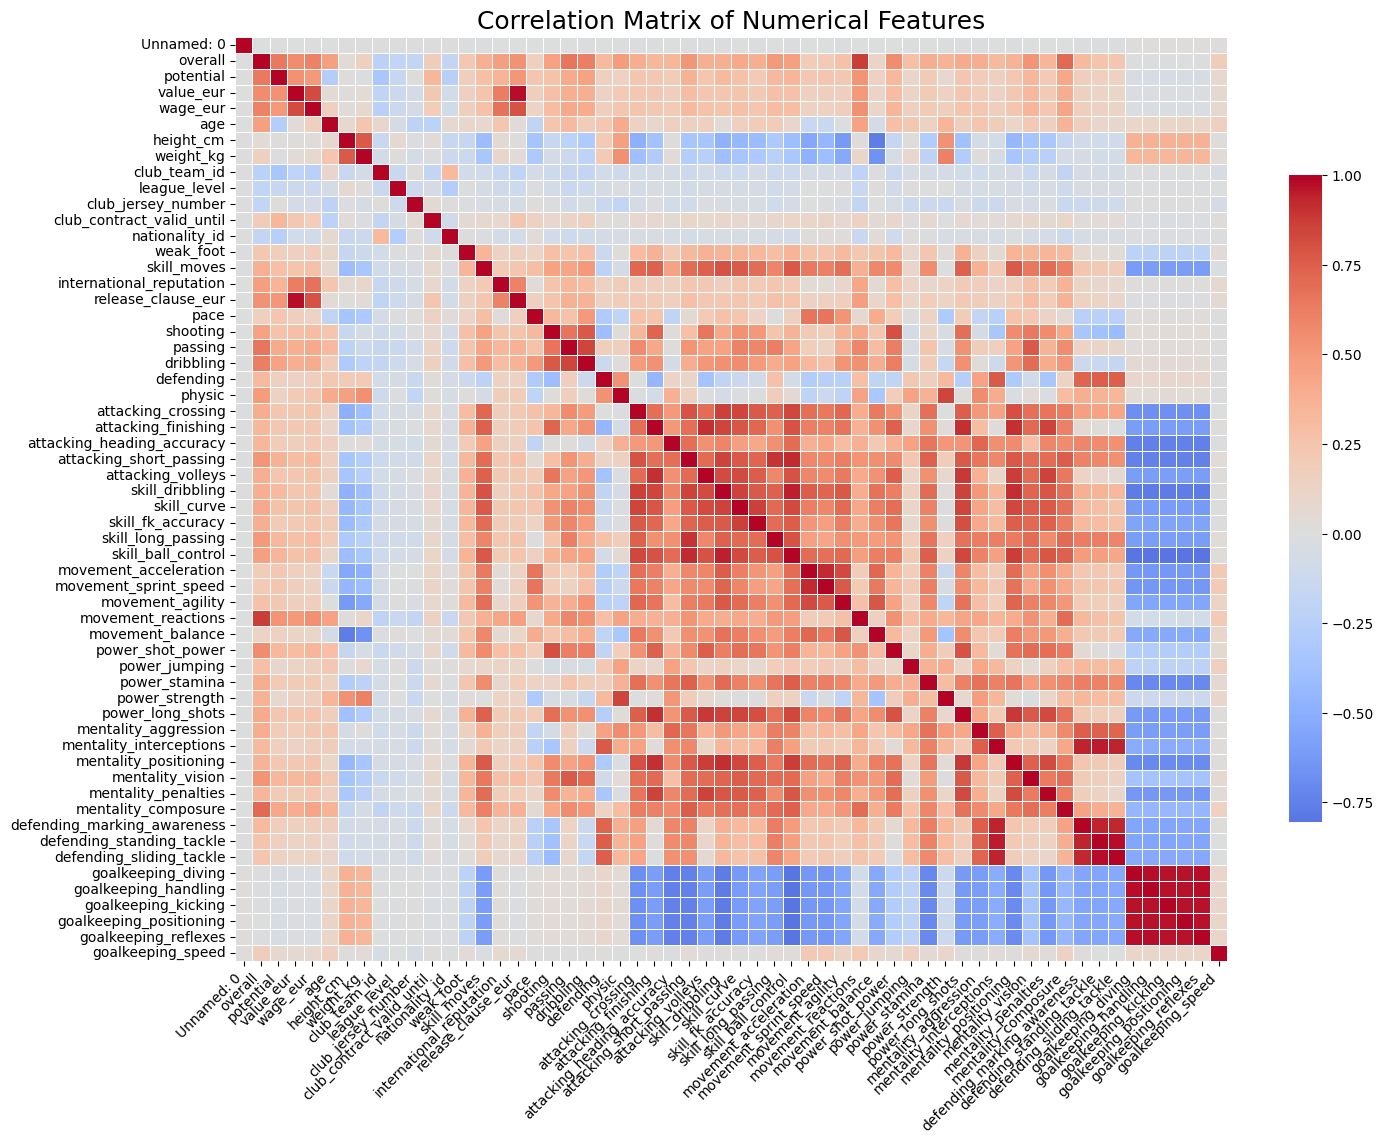

🔼 Top 10 Positive Correlations with value_eur:

release_clause_eur          0.977855
wage_eur                    0.823089
international_reputation    0.629600
overall                     0.556989
potential                   0.527815
movement_reactions          0.495787
mentality_composure         0.391349
passing                     0.383914
dribbling                   0.382258
mentality_vision            0.323636
Name: value_eur, dtype: float64

🔽 Top 10 Negative Correlations with value_eur:

club_team_id              -0.196020
league_level              -0.118714
nationality_id            -0.084610
club_jersey_number        -0.065937
goalkeeping_diving        -0.023641
goalkeeping_handling      -0.022832
goalkeeping_positioning   -0.022782
goalkeeping_kicking       -0.022042
goalkeeping_reflexes      -0.020454
Unnamed: 0                -0.001885
Name: value_eur, dtype: float64

🔗 Highly Correlated Feature Pairs (r > 0.80):
  - overall ↔ movement_reactions  |  Correlation: 0.87
  - pas

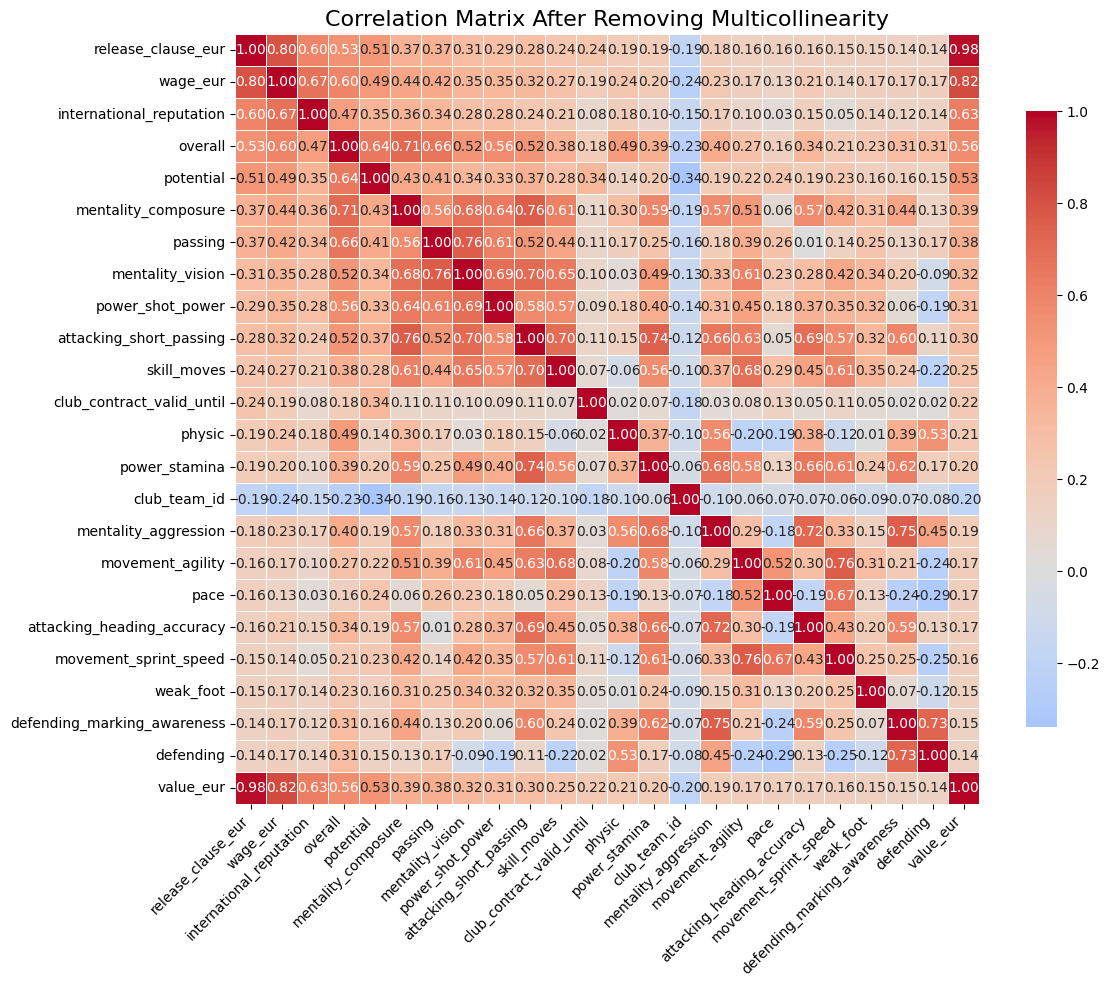

In [ ]:
# A. Correlation among features
# 1. Select only numerical columns (exclude categorical ones)
train = pd.read_csv("train_Clean.csv")
train_numerical = train.select_dtypes(include=['number'])

# 2. Calculate the full correlation matrix
correlations = train_numerical.corr()

# 3. Visualize the full correlation matrix
print("🎯Correlation Matrix of numeric features:\n")
plt.figure(figsize=(16, 12))
sns.heatmap(correlations, 
            cmap='coolwarm', 
            center=0, 
            annot=False, 
            fmt='.2f', 
            linewidths=0.5, 
            cbar_kws={'shrink': 0.7})
plt.title('Correlation Matrix of Numerical Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# B. Correlation features with Value_eur 
#Find correlation of features with value_eur
value_corr = correlations['value_eur'].drop('value_eur')  # remove self-correlation

# Top 10 positively correlated features
top10_pos = value_corr.sort_values(ascending=False).head(10) 
print("🔼 Top 10 Positive Correlations with value_eur:\n")
print(top10_pos)
# Top 10 negatively correlated features
top10_neg = value_corr.sort_values(ascending=True).head(10)
print("\n🔽 Top 10 Negative Correlations with value_eur:\n")
print(top10_neg)


# C. Top Features Correlating with Value_eur without Multicollinearity
# Reselect top 40 absolute correlation with value_eur  
top40_features = value_corr.abs().sort_values(ascending=False).head(40).index.tolist()

# Create a correlation matrix of the selected features
corr_matrix = train_numerical[top40_features].corr().abs()

# Keep upper triangle (no duplicates)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated pairs (above threshold)
high_corr_pairs = []
for col in upper_triangle.columns:
    for row in upper_triangle.index:
        corr_value = upper_triangle.loc[row, col]
        if pd.notnull(corr_value) and corr_value > 0.80:
            high_corr_pairs.append((row, col, round(corr_value, 2)))

# Print high correlation pairs
print("\n🔗 Highly Correlated Feature Pairs (r > 0.80):")
if high_corr_pairs:
    for row, col, score in high_corr_pairs:
        print(f"  - {row} ↔ {col}  |  Correlation: {score}")
else:
    print("  None found.")

# Remove one feature from each pair (keep the first, drop the second)
redundant_features = {col for _, col, _ in high_corr_pairs}
final_selected_features = [f for f in top40_features if f not in redundant_features]


# Final list of selected features
print("\n✅ Final Features after Removing Multicollinearity:")
for i, feat in enumerate(final_selected_features, 1):
    print(f"  {i}. {feat}")

# Create correlation matrix for the final selected features + value_eur
final_plus_value = final_selected_features + ['value_eur']
final_corr_matrix = train_numerical[final_plus_value].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(final_corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix After Removing Multicollinearity', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

---
---

# 2| PAST MODELS
## 2.1| Linear regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

#  Load the cleaned training and test datasets
train = pd.read_csv("train_Clean.csv")
test = pd.read_csv("test_Clean.csv")

# List of features to keep (Top 22 features that correlate with value_eur, without multicollinearity) List from section 1.5 C minus 'club_contract_valid_until' might create extra noise.
selected_features = [
    'release_clause_eur', 'value_eur', 'wage_eur', 'international_reputation', 'overall', 'potential',
    'mentality_composure', 'passing', 'mentality_vision', 'power_shot_power',
    'attacking_short_passing', 'skill_moves', 'physic',
    'power_stamina', 'club_team_id', 'mentality_aggression', 'movement_agility', 'pace',
    'attacking_heading_accuracy', 'movement_sprint_speed', 'weak_foot',
    'defending_marking_awareness', 'defending'
]
# Create new DataFrame with only the selected features
train_filtered = train[selected_features].copy()  # Using .copy() to avoid SettingWithCopyWarning

# Verify the new DataFrame
print(f"\nShape of filtered DataFrame: {train_filtered.shape}")

# Define features (X) and target (y) for train and test
X = train_filtered.drop(columns=['value_eur'], errors='ignore')  # Features
Y = train_filtered['value_eur']  # Target (replace 'value_eur' if your target has a different name)

# Split into training and validation sets
x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression on training portion only
model = LinearRegression()
model.fit(x_tr, y_tr)

# Predict on validation set
y_pred = model.predict(x_val)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print results
print("Linear Regression Results:")
print(f"Validation RMSE:\t{rmse:,.4f}")
print(f"Validation R²:\t\t{r2:.4f}")


Shape of filtered DataFrame: (15391, 23)
Linear Regression Results:
Validation RMSE:	1,382,404.6253
Validation R²:		0.9614


## 2.2| Random Forest

In [ ]:
## import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv("train_Clean.csv")
test = pd.read_csv("test_Clean.csv")

# Separate target variable
y = train["value_eur"]
X = train.drop(columns=["value_eur"])

# Drop non-numeric columns
print(X.select_dtypes(include=["number"]))
X = X.select_dtypes(include=["number"])
test = test.select_dtypes(include=["number"])


# Initialize Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation RMSE
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
print(f"Cross-validated RMSE: {-np.mean(scores):,.2f}")

# Train final model and predict
model.fit(X, y)
predictions = model.predict(test)

Cross-validated RMSE: 881,151.21


---
---

# 3| MAIN MODEL
## 3.1| LightGBM

In [ ]:
# --- INSTALL if needed ---
# !pip install lightgbm optuna scikit-learn pandas

# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import math
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# --- LOAD DATA ---
train_df = pd.read_csv("train_Clean.csv")
test_df = pd.read_csv("test_Clean.csv")

# --- REMOVE OUTLIERS ---
train_df = train_df[train_df['value_eur'] < 100_000_000]

# --- SPLIT FEATURES AND TARGET ---
X = train_df.drop(columns=['value_eur'])
y = train_df['value_eur']

# --- CLEAN COLUMN NAMES for LightGBM ---
X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
test_df.columns = test_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# --- SUPER FEATURE ENGINEERING ---
if set(['passing', 'shooting', 'dribbling']).issubset(X.columns):
    X['total_skill'] = X['passing'] + X['shooting'] + X['dribbling']
    test_df['total_skill'] = test_df['passing'] + test_df['shooting'] + test_df['dribbling']

if set(['finishing', 'volleys', 'positioning']).issubset(X.columns):
    X['attacking_skill'] = X['finishing'] + X['volleys'] + X['positioning']
    test_df['attacking_skill'] = test_df['finishing'] + test_df['volleys'] + test_df['positioning']

if set(['interceptions', 'defensive_awareness', 'standing_tackle']).issubset(X.columns):
    X['defending_skill'] = X['interceptions'] + X['defensive_awareness'] + X['standing_tackle']
    test_df['defending_skill'] = test_df['interceptions'] + test_df['defensive_awareness'] + test_df['standing_tackle']

if set(['gk_diving', 'gk_handling', 'gk_kicking']).issubset(X.columns):
    X['goalkeeping_skill'] = X['gk_diving'] + X['gk_handling'] + X['gk_kicking']
    test_df['goalkeeping_skill'] = test_df['gk_diving'] + test_df['gk_handling'] + test_df['gk_kicking']

if 'age' in X.columns:
    X['age_squared'] = X['age'] ** 2
    test_df['age_squared'] = test_df['age'] ** 2

# --- ENCODING CATEGORICAL FEATURES ---
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# --- TARGET TRANSFORMATION ---
y_log = np.log1p(y)  # log(value + 1)

# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'n_estimators': 10000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.003, 0.03),
        'num_leaves': trial.suggest_int('num_leaves', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'random_state': 42,
        'n_jobs': -1
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(X.shape[0])

    for train_idx, valid_idx in kf.split(X):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_log.iloc[train_idx], y_log.iloc[valid_idx]
        
        lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
        lgb_valid = lgb.Dataset(X_valid_cv, y_valid_cv)
        
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)
            ]
        )
        
        oof_preds[valid_idx] = model.predict(X_valid_cv)
        
    rmse = math.sqrt(mean_squared_error(y_log, oof_preds))
    return rmse

# --- RUN OPTUNA STUDY ---
print("🔍 Starting hyperparameter tuning...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # increase to 100+ if you have time!

print("✅ Best params:", study.best_params)
print("✅ Best CV RMSE:", study.best_value)

# --- FINAL MODEL TRAINING ---
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'n_estimators': 10000,
    'random_state': 42,
    'n_jobs': -1
})

kf = KFold(n_splits=5, shuffle=True, random_state=42)
test_preds_log = np.zeros(test_df.shape[0])

for train_idx, valid_idx in kf.split(X):
    X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_cv, y_valid_cv = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
    lgb_valid = lgb.Dataset(X_valid_cv, y_valid_cv)
    
    model = lgb.train(
        best_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]
    )
    
    test_preds_log += model.predict(test_df) / 5

# --- INVERSE TRANSFORM THE PREDICTIONS ---
test_preds = np.expm1(test_preds_log)

# --- SAVE FINAL SUBMISSION FILE ---
try:
    submission = pd.read_csv('submission.csv')
except FileNotFoundError:
    submission = pd.DataFrame()
    submission['id'] = np.arange(len(test_preds))

submission['value_eur'] = test_preds
submission.to_csv('final_submission_superboosted.csv', index=False)

print("✅ FINAL submission file saved: final_submission_superboosted.csv")

# --- Inverse transform validation ---
val_preds_log = model.predict(X_valid_cv)
val_preds_real = np.expm1(val_preds_log)
y_valid_real = np.expm1(y_valid_cv)

# --- Real RMSE ---
from sklearn.metrics import mean_squared_error
real_rmse = math.sqrt(mean_squared_error(y_valid_real, val_preds_real))
print(f"🎯 Real Validation RMSE (Euros): {real_rmse:.2f}")